<a href="https://colab.research.google.com/github/fralfaro/r4ds-book/blob/main/docs/23_model_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model basics

## Introduction

The goal of a model is to provide a simple low-dimensional summary of a dataset. In the context of this book we're going to use models to partition data into patterns and residuals. Strong patterns will hide subtler trends, so we'll use models to help peel back layers of structure as we explore a dataset.

However, before we can start using models on interesting, real, datasets, you need to understand the basics of how models work. For that reason, this chapter of the book is unique because it uses only simulated datasets. These datasets are very simple, and not at all interesting, but they will help you understand the essence of modelling before you apply the same techniques to real data in the next chapter.

There are two parts to a model:

1.  First, you define a __family of models__ that express a precise, but 
    generic, pattern that you want to capture. For example, the pattern 
    might be a straight line, or a quadratic curve. You will express
    the model family as an equation like `y = a_1 * x + a_2` or 
    `y = a_1 * x ^ a_2`. Here, `x` and `y` are known variables from your
    data, and `a_1` and `a_2` are parameters that can vary to capture 
    different patterns.

1.  Next, you generate a __fitted model__ by finding the model from the 
    family that is the closest to your data. This takes the generic model 
    family and makes it specific, like `y = 3 * x + 7` or `y = 9 * x ^ 2`.

It's important to understand that a fitted model is just the closest model from a family of models. That implies that you have the "best" model (according to some criteria); it doesn't imply that you have a good model and it certainly doesn't imply that the model is "true". George Box puts this well in his famous aphorism:

> All models are wrong, but some are useful.

It's worth reading the fuller context of the quote:

> Now it would be very remarkable if any system existing in the real world 
> could be exactly represented by any simple model. However, cunningly chosen 
> parsimonious models often do provide remarkably useful approximations. For 
> example, the law PV = RT relating pressure P, volume V and temperature T of 
> an "ideal" gas via a constant R is not exactly true for any real gas, but it 
> frequently provides a useful approximation and furthermore its structure is 
> informative since it springs from a physical view of the behavior of gas 
> molecules.
> 
> For such a model there is no need to ask the question "Is the model true?". 
> If "truth" is to be the "whole truth" the answer must be "No". The only 
> question of interest is "Is the model illuminating and useful?".

The goal of a model is not to uncover truth, but to discover a simple approximation that is still useful. 

### Prerequisites

In this chapter we'll use the modelr package which wraps around base R's modelling functions to make them work naturally in a pipe.



In [1]:
library(tidyverse)

library(modelr)
options(na.action = na.warn)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()




## A simple model

Lets take a look at the simulated dataset `sim1`, included with the modelr package. It contains two continuous variables, `x` and `y`. Let's plot them to see how they're related:


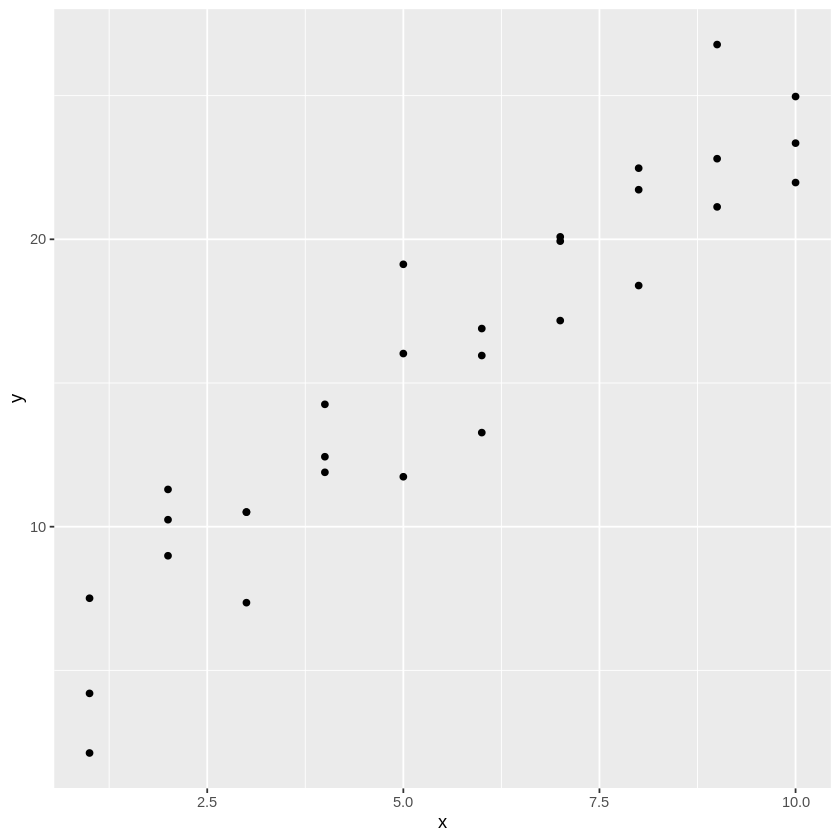

In [2]:
ggplot(sim1, aes(x, y)) + 
  geom_point()


You can see a strong pattern in the data. Let's use a model to capture that pattern and make it explicit. It's our job to supply the basic form of the model. In this case, the relationship looks linear, i.e. `y = a_0 + a_1 * x`.  Let's start by getting a feel for what models from that family look like by randomly generating a few and overlaying them on the data. For this simple case, we can use `geom_abline()` which takes a slope and intercept as parameters. Later on we'll learn more general techniques that work with any model.


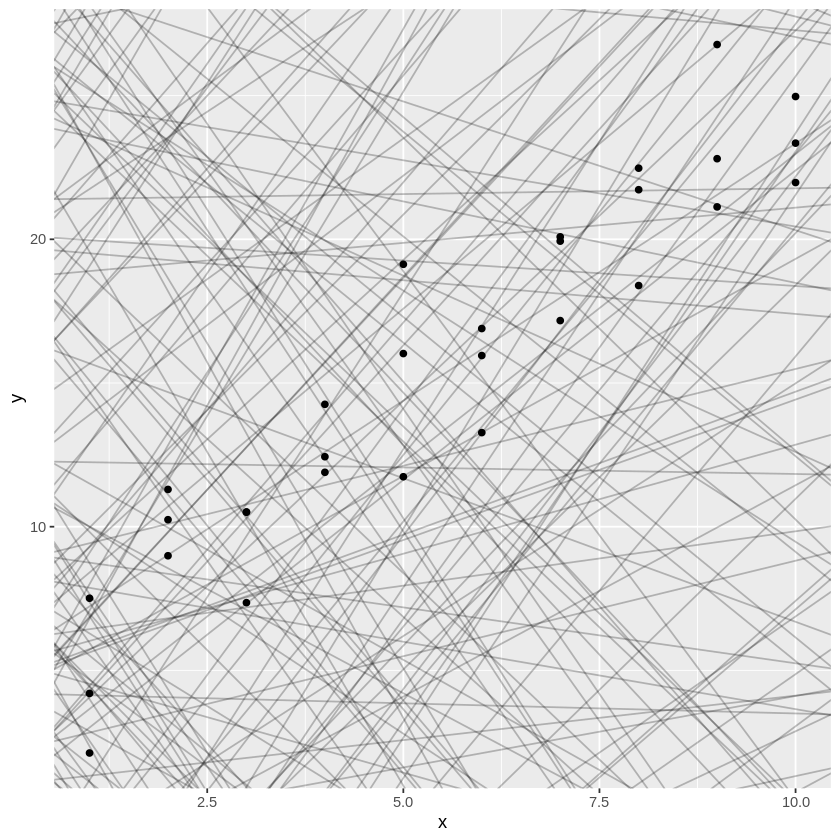

In [3]:
models <- tibble(
  a1 = runif(250, -20, 40),
  a2 = runif(250, -5, 5)
)

ggplot(sim1, aes(x, y)) + 
  geom_abline(aes(intercept = a1, slope = a2), data = models, alpha = 1/4) +
  geom_point() 


There are 250 models on this plot, but a lot are really bad! We need to find the good models by making precise our intuition that a good model is "close" to the data. We need a way to quantify the distance between the data and a model. Then we can fit the model by finding the value of `a_0` and `a_1` that generate the model with the smallest distance from this data.

One easy place to start is to find the vertical distance between each point and the model, as in the following diagram. (Note that I've shifted the x values slightly so you can see the individual distances.)


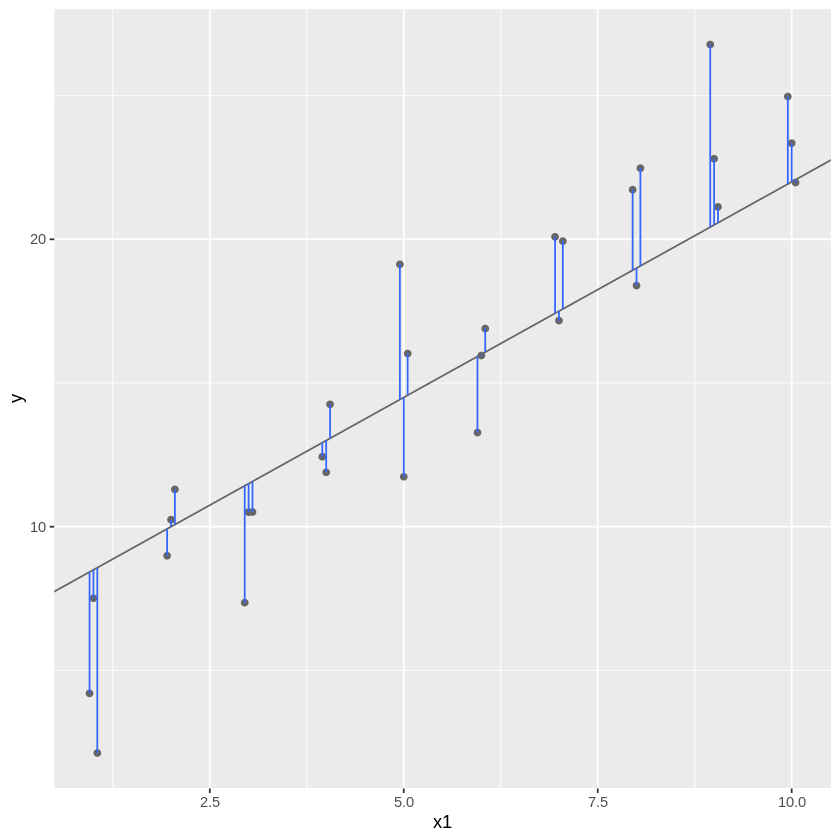

In [4]:
dist1 <- sim1 %>% 
  mutate(
    dodge = rep(c(-1, 0, 1) / 20, 10),
    x1 = x + dodge,
    pred = 7 + x1 * 1.5
  )

ggplot(dist1, aes(x1, y)) + 
  geom_abline(intercept = 7, slope = 1.5, colour = "grey40") +
  geom_point(colour = "grey40") +
  geom_linerange(aes(ymin = y, ymax = pred), colour = "#3366FF") 


This distance is just the difference between the y value given by the model (the __prediction__), and the actual y value in the data (the __response__).

To compute this distance, we first turn our model family into an R function. This takes the model parameters and the data as inputs, and gives values predicted by the model as output:


In [5]:
model1 <- function(a, data) {
  a[1] + data$x * a[2]
}
model1(c(7, 1.5), sim1)

[1]  8.5  8.5  8.5 10.0 10.0 10.0 11.5 11.5 11.5 13.0 13.0 13.0 14.5 14.5 14.5
[16] 16.0 16.0 16.0 17.5 17.5 17.5 19.0 19.0 19.0 20.5 20.5 20.5 22.0 22.0 22.0


Next, we need some way to compute an overall distance between the predicted and actual values. In other words, the plot above shows 30 distances: how do we collapse that into a single number?

One common way to do this in statistics to use the "root-mean-squared deviation". We compute the difference between actual and predicted, square them, average them, and the take the square root. This distance has lots of appealing mathematical properties, which we're not going to talk about here. You'll just have to take my word for it!



In [6]:
measure_distance <- function(mod, data) {
  diff <- data$y - model1(mod, data)
  sqrt(mean(diff ^ 2))
}
measure_distance(c(7, 1.5), sim1)

[1] 2.665212


Now we can use purrr to compute the distance for all the models defined above. We need a helper function because our distance function expects the model as a numeric vector of length 2.


In [7]:
sim1_dist <- function(a1, a2) {
  measure_distance(c(a1, a2), sim1)
}

models <- models %>% 
  mutate(dist = purrr::map2_dbl(a1, a2, sim1_dist))
models

a1,a2,dist
<dbl>,<dbl>,<dbl>
35.4811685,2.5601648,34.155507
-7.6966399,-4.5438026,51.825107
24.7030341,4.7803950,36.408406
-1.8412356,-2.9214498,36.400767
-17.2417596,-2.3012866,47.141095
-2.7106016,-1.8720188,30.731199
3.8791145,-2.1623631,26.535382
-16.2713319,2.3395956,19.045183
-12.2166503,-1.1995196,35.629613



Next, let's overlay the 10 best models on to the data. I've coloured the models by `-dist`: this is an easy way to make sure that the best models (i.e. the ones with the smallest distance) get the brighest colours.


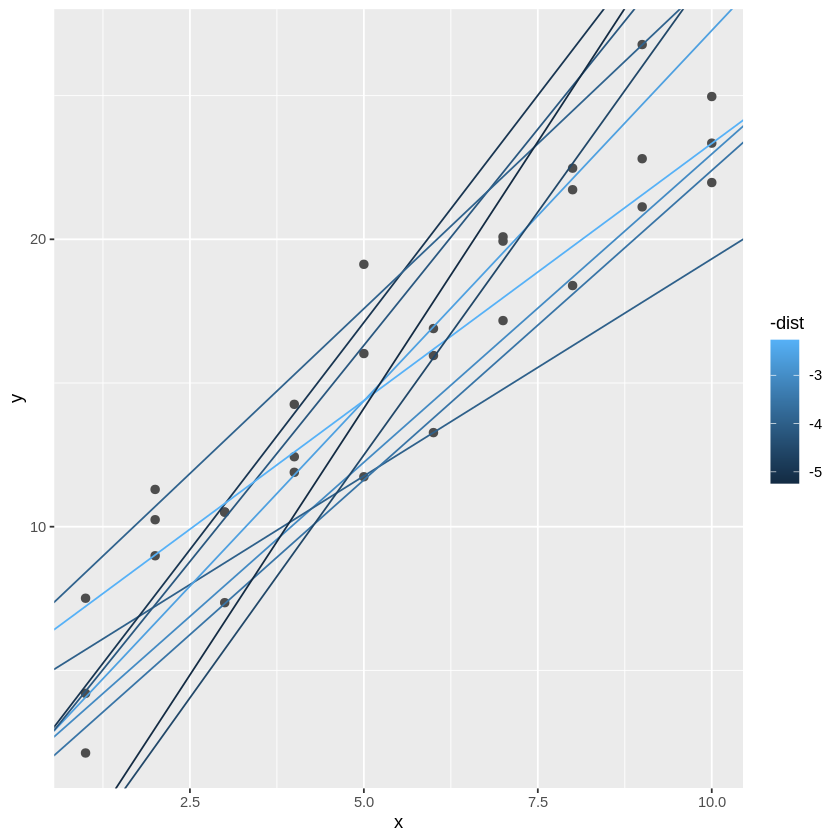

In [8]:
ggplot(sim1, aes(x, y)) + 
  geom_point(size = 2, colour = "grey30") + 
  geom_abline(
    aes(intercept = a1, slope = a2, colour = -dist), 
    data = filter(models, rank(dist) <= 10)
  )


We can also think about these models as observations, and visualising with a scatterplot of `a1` vs  `a2`, again coloured by `-dist`. We can no longer directly see how the model compares to the data, but we can see many models at once. Again, I've highlighted the 10 best models, this time by drawing red circles underneath them.


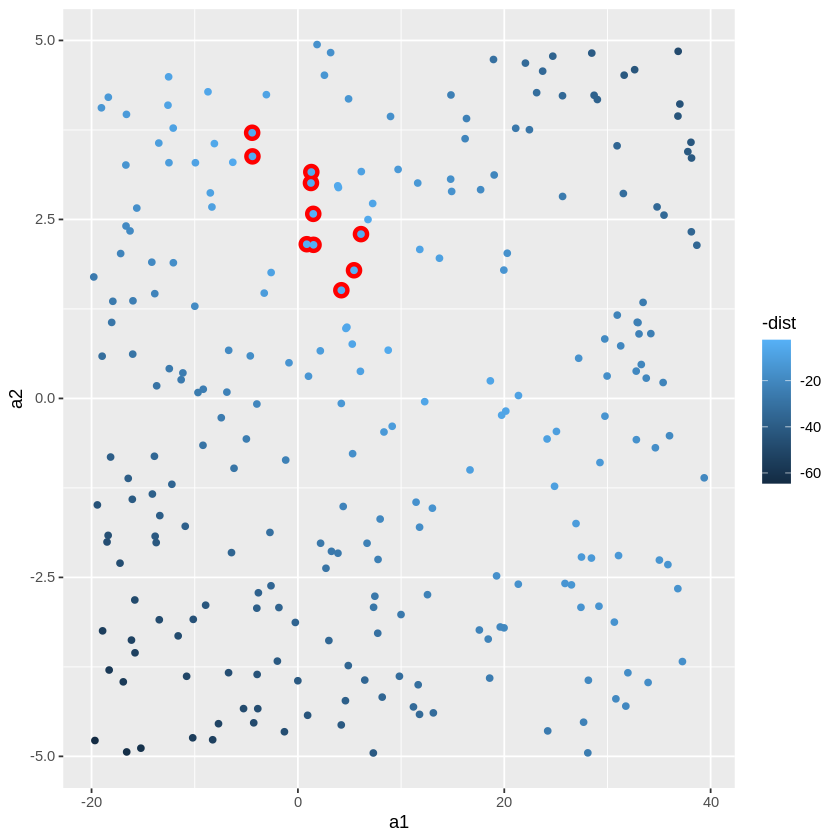

In [9]:
ggplot(models, aes(a1, a2)) +
  geom_point(data = filter(models, rank(dist) <= 10), size = 4, colour = "red") +
  geom_point(aes(colour = -dist))


Instead of trying lots of random models, we could be more systematic and generate an evenly spaced grid of points (this is called a grid search). I picked the parameters of the grid roughly by looking at where the best models were in the plot above.


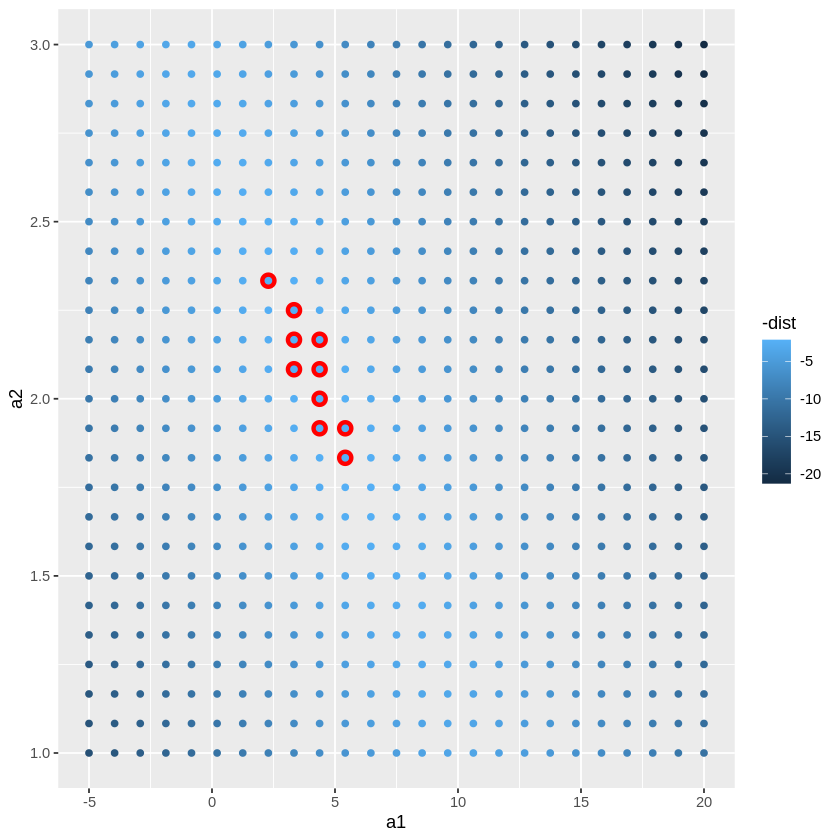

In [10]:
grid <- expand.grid(
  a1 = seq(-5, 20, length = 25),
  a2 = seq(1, 3, length = 25)
  ) %>% 
  mutate(dist = purrr::map2_dbl(a1, a2, sim1_dist))

grid %>% 
  ggplot(aes(a1, a2)) +
  geom_point(data = filter(grid, rank(dist) <= 10), size = 4, colour = "red") +
  geom_point(aes(colour = -dist)) 


When you overlay the best 10 models back on the original data, they all look pretty good:


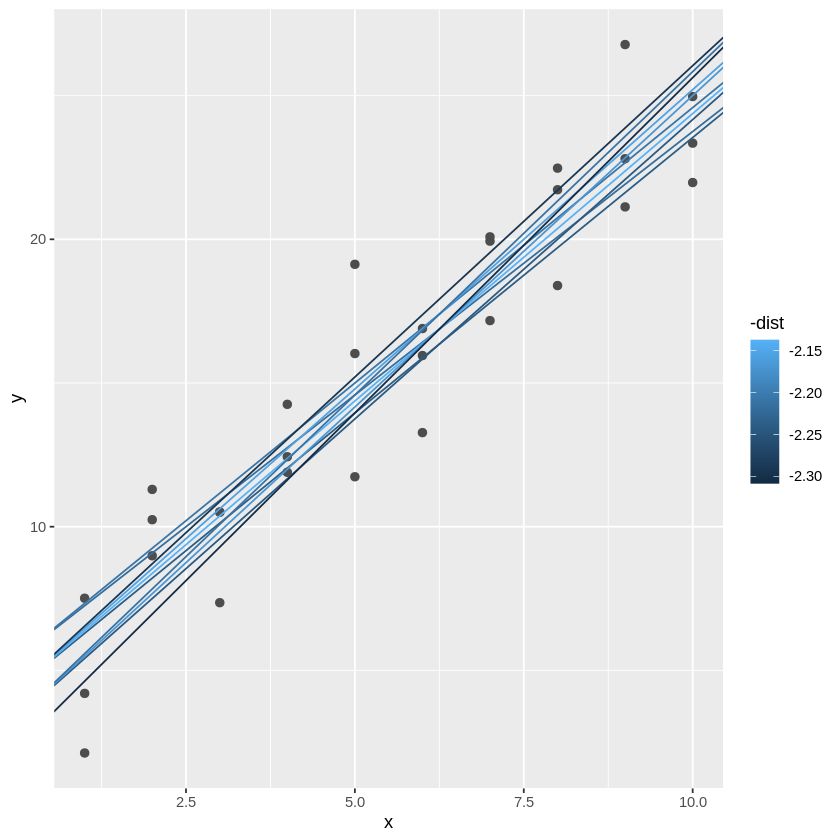

In [11]:
ggplot(sim1, aes(x, y)) + 
  geom_point(size = 2, colour = "grey30") + 
  geom_abline(
    aes(intercept = a1, slope = a2, colour = -dist), 
    data = filter(grid, rank(dist) <= 10)
  )


You could imagine iteratively making the grid finer and finer until you narrowed in on the best model. But there's a better way to tackle that problem: a numerical minimisation tool called Newton-Raphson search. The intuition of Newton-Raphson is pretty simple: you pick a starting point and look around for the steepest slope. You then ski down that slope a little way, and then repeat again and again, until you can't go any lower. In R, we can do that with `optim()`:


[1] 4.222248 2.051204

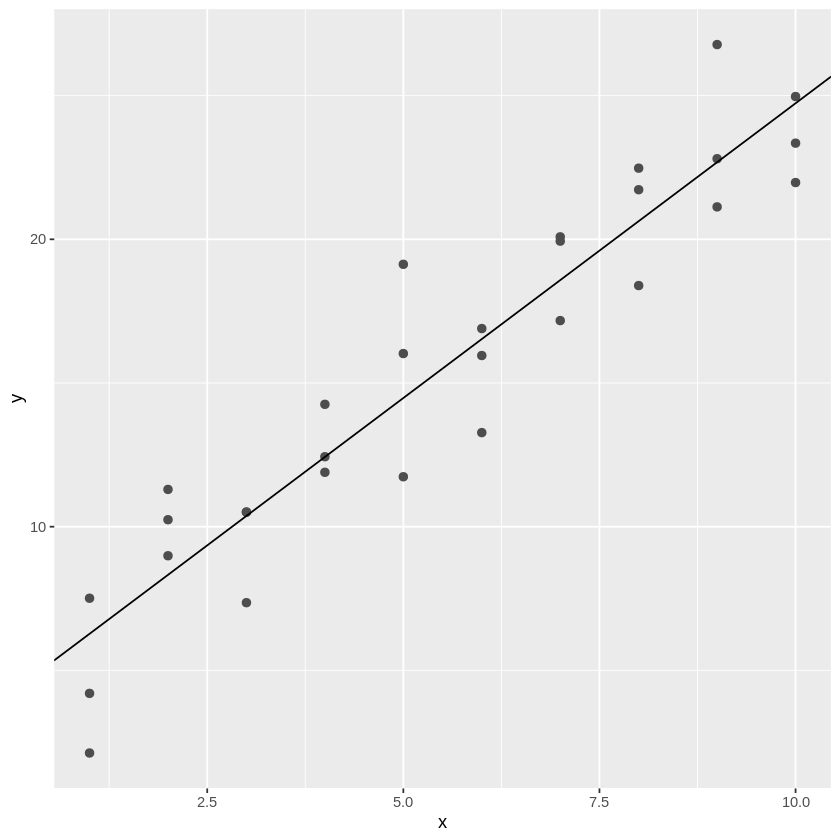

In [12]:
best <- optim(c(0, 0), measure_distance, data = sim1)
best$par

ggplot(sim1, aes(x, y)) + 
  geom_point(size = 2, colour = "grey30") + 
  geom_abline(intercept = best$par[1], slope = best$par[2])


Don't worry too much about the details of how `optim()` works. It's the intuition that's important here. If you have a function that defines the distance between a model and a dataset, an algorithm that can minimise that distance by modifying the parameters of the model can find the best model. The neat thing about this approach is that it will work for any family of models that you can write an equation for. 

There's one more approach that we can use for this model, because it's a special case of a broader family: linear models. A linear model has the general form `y = a_1 + a_2 * x_1 + a_3 * x_2 + ... + a_n * x_(n - 1)`. So this simple model is equivalent to a general linear model where n is 2 and `x_1` is `x`. R has a tool specifically designed for fitting linear models called `lm()`. `lm()` has a special way to specify the model family: formulas. Formulas look like `y ~ x`, which `lm()` will translate to a function like `y = a_1 + a_2 * x`. We can fit the model and look at the output:


In [13]:
sim1_mod <- lm(y ~ x, data = sim1)
coef(sim1_mod)

(Intercept)           x 
   4.220822    2.051533


```{r}
sim1_mod <- lm(y ~ x, data = sim1)
coef(sim1_mod)
```



These are exactly the same values we got with `optim()`! Behind the scenes `lm()` doesn't use `optim()` but instead takes advantage of the mathematical structure of linear models. Using some connections between geometry, calculus, and linear algebra, `lm()` actually finds the closest model in a single step, using a sophisticated algorithm. This approach is both faster, and guarantees that there is a global minimum.

### Exercises

1.  One downside of the linear model is that it is sensitive to unusual values
    because the distance incorporates a squared term. Fit a linear model to 
    the simulated data below, and visualise the results. Rerun a few times to
    generate different simulated datasets. What do you notice about the model? 
  
    ```r
    sim1a <- tibble(
      x = rep(1:10, each = 3),
      y = x * 1.5 + 6 + rt(length(x), df = 2)
    )
    ```

1.  One way to make linear models more robust is to use a different distance
    measure. For example, instead of root-mean-squared distance, you could use
    mean-absolute distance:
  
    ```r
    measure_distance <- function(mod, data) {
      diff <- data$y - model1(mod, data)
      mean(abs(diff))
    }
    ```

   Use `optim()` to fit this model to the simulated data above and compare it to the linear model.

1. One challenge with performing numerical optimisation is that it’s only guaranteed to find one local optimum. What’s the problem with optimising a three parameter model like this?

  ```r
  model1 <- function(a, data) {
  a[1] + data$x * a[2] + a[3]
  }
  ```


## Visualising models

For simple models, like the one above, you can figure out what pattern the model captures by carefully studying the model family and the fitted coefficients. And if you ever take a statistics course on modelling, you're likely to spend a lot of time doing just that. Here, however, we're going to take a different tack. We're going to focus on understanding a model by looking at its predictions. This has a big advantage: every type of predictive model makes predictions (otherwise what use would it be?) so we can use the same set of techniques to understand any type of predictive model.

It's also useful to see what the model doesn't capture, the so-called residuals which are left after subtracting the predictions from the data. Residuals are powerful because they allow us to use models to remove striking patterns so we can study the subtler trends that remain.

### Predictions

To visualise the predictions from a model, we start by generating an evenly spaced grid of values that covers the region where our data lies. The easiest way to do that is to use `modelr::data_grid()`. Its first argument is a data frame, and for each subsequent argument it finds the unique variables and then generates all combinations:



In [14]:
grid <- sim1 %>% 
  data_grid(x) 
grid

x
<int>
1
2
3
4
5
6
7
8
9



(This will get more interesting when we start to add more variables to our model.)

Next we add predictions. We'll use `modelr::add_predictions()` which takes a data frame and a model. It adds the predictions from the model to a new column in the data frame:



In [15]:
grid <- grid %>% 
  add_predictions(sim1_mod) 
grid

x,pred
<int>,<dbl>
1,6.272355
2,8.323888
3,10.375421
4,12.426954
5,14.478487
6,16.530020
7,18.581553
8,20.633087
9,22.684620



(You can also use this function to add predictions to your original dataset.)

Next, we plot the predictions. You might wonder about all this extra work compared to just using `geom_abline()`. But the advantage of this approach is that it will work with _any_ model in R, from the simplest to the most complex. You're only limited by your visualisation skills. For more ideas about how to visualise more complex model types, you might try <http://vita.had.co.nz/papers/model-vis.html>.



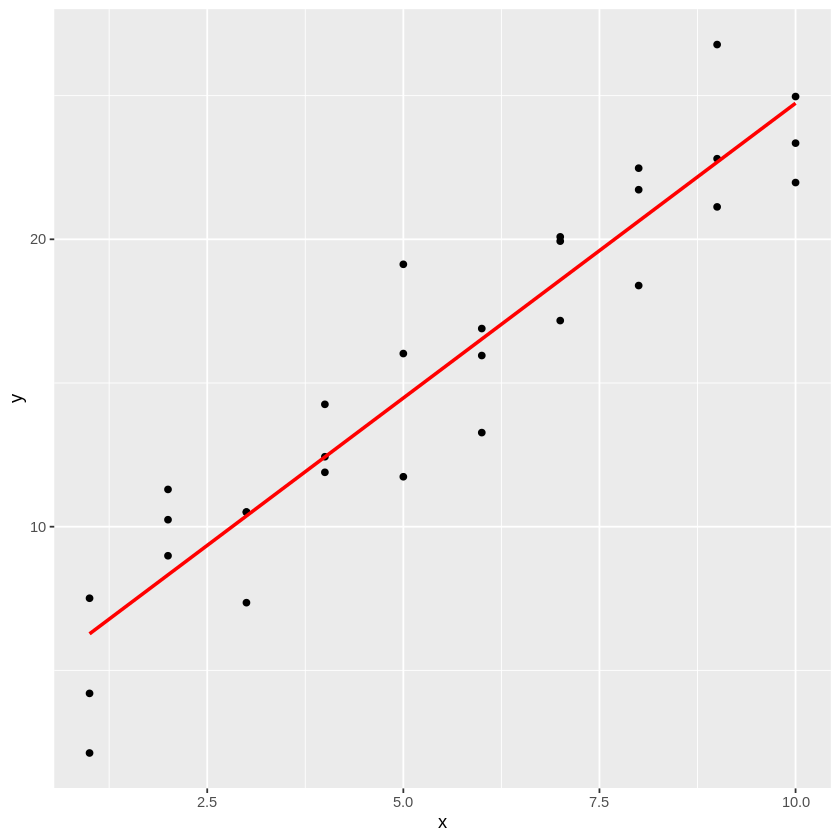

In [16]:
ggplot(sim1, aes(x)) +
  geom_point(aes(y = y)) +
  geom_line(aes(y = pred), data = grid, colour = "red", size = 1)



### Residuals

The flip-side of predictions are __residuals__. The predictions tells you the pattern that the model has captured, and the residuals tell you what the model has missed. The residuals are just the distances between the observed and predicted values that we computed above. 

We add residuals to the data with `add_residuals()`, which works much like `add_predictions()`. Note, however, that we use the original dataset, not a manufactured grid. This is because to compute residuals we need actual y values.



In [17]:
sim1 <- sim1 %>% 
  add_residuals(sim1_mod)
sim1

x,y,resid
<int>,<dbl>,<dbl>
1,4.199913,-2.072442018
1,7.510634,1.238279125
1,2.125473,-4.146882207
2,8.988857,0.664969362
2,10.243105,1.919217378
2,11.296823,2.972935148
3,7.356365,-3.019056466
3,10.505349,0.129928252
3,10.511601,0.136179642



There are a few different ways to understand what the residuals tell us about the model. One way is to simply draw a frequency polygon to help us understand the spread of the residuals:



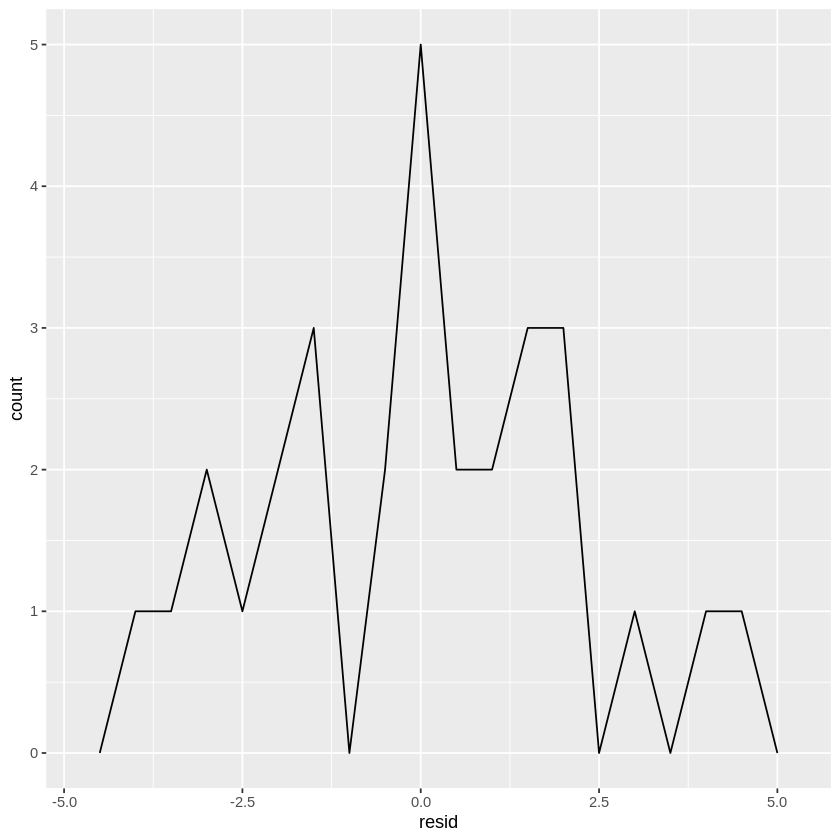

In [18]:
ggplot(sim1, aes(resid)) + 
  geom_freqpoly(binwidth = 0.5)


This helps you calibrate the quality of the model: how far away are the predictions from the observed values?  Note that the average of the residual will always be 0.

You'll often want to recreate plots using the residuals instead of the original predictor. You'll see a lot of that in the next chapter.



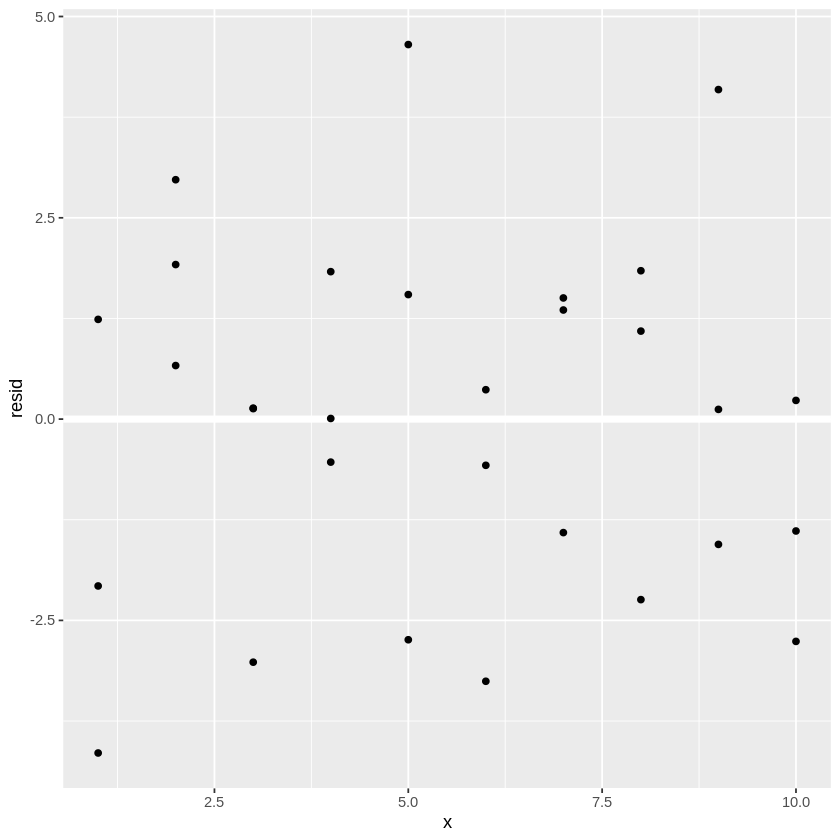

In [19]:
ggplot(sim1, aes(x, resid)) + 
  geom_ref_line(h = 0) +
  geom_point() 



This looks like random noise, suggesting that our model has done a good job of capturing the patterns in the dataset.

### Exercises

1.  Instead of using `lm()` to fit a straight line, you can use `loess()`
    to fit a smooth curve. Repeat the process of model fitting, 
    grid generation, predictions, and visualisation on `sim1` using 
    `loess()` instead of `lm()`. How does the result compare to 
    `geom_smooth()`?
    
1.  `add_predictions()` is paired with `gather_predictions()` and 
    `spread_predictions()`. How do these three functions differ?
    
1.  What does `geom_ref_line()` do? What package does it come from?
    Why is displaying a reference line in plots showing residuals
    useful and important?
    
1.  Why might you want to look at a frequency polygon of absolute residuals?
    What are the pros and cons compared to looking at the raw residuals?

## Formulas and model families

You've seen formulas before when using `facet_wrap()` and `facet_grid()`. In R, formulas provide a general way of getting "special behaviour". Rather than evaluating the values of the variables right away, they capture them so they can be interpreted by the function.

The majority of modelling functions in R use a standard conversion from formulas to functions. You've seen one simple conversion already: `y ~ x` is translated to `y = a_1 + a_2 * x`.  If you want to see what R actually does, you can use the `model_matrix()` function. It takes a data frame and a formula and returns a tibble that defines the model equation: each column in the output is associated with one coefficient in the model, the function is always `y = a_1 * out_1 + a_2 * out_2`. For the simplest case of `y ~ x1` this shows us something interesting:



In [20]:
df <- tribble(
  ~y, ~x1, ~x2,
  4, 2, 5,
  5, 1, 6
)
model_matrix(df, y ~ x1)

(Intercept),x1
<dbl>,<dbl>
1,2
1,1



The way that R adds the intercept to the model is just by having a column that is full of ones.  By default, R will always add this column. If you don't want, you need to explicitly drop it with `-1`:



In [21]:
model_matrix(df, y ~ x1 - 1)

x1
<dbl>
2
1



The model matrix grows in an unsurprising way when you add more variables to the model:



In [22]:
model_matrix(df, y ~ x1 + x2)

(Intercept),x1,x2
<dbl>,<dbl>,<dbl>
1,2,5
1,1,6



This formula notation is sometimes called "Wilkinson-Rogers notation", and was initially described in _Symbolic Description of Factorial Models for Analysis of Variance_, by G. N. Wilkinson and C. E. Rogers <https://www.jstor.org/stable/2346786>. It's worth digging up and reading the original paper if you'd like to understand the full details of the modelling algebra.

The following sections expand on how this formula notation works for categorical variables, interactions, and transformation.

### Categorical variables

Generating a function from a formula is straight forward when the predictor is continuous, but things get a bit more complicated when the predictor is categorical. Imagine you have a formula like `y ~ sex`, where sex could either be male or female. It doesn't make sense to convert that to a formula like `y = x_0 + x_1 * sex` because `sex` isn't a number - you can't multiply it! Instead what R does is convert it to `y = x_0 + x_1 * sex_male` where `sex_male` is one if `sex` is male and zero otherwise:



In [23]:
df <- tribble(
  ~ sex, ~ response,
  "male", 1,
  "female", 2,
  "male", 1
)
model_matrix(df, response ~ sex)

(Intercept),sexmale
<dbl>,<dbl>
1,1
1,0
1,1



You might wonder why R also doesn't create a `sexfemale` column. The problem is that would create a column that is perfectly predictable based on the other columns (i.e. `sexfemale = 1 - sexmale`). Unfortunately the exact details of why this is a problem is beyond the scope of this book, but basically it creates a model family that is too flexible, and will have infinitely many models that are equally close to the data.

Fortunately, however, if you focus on visualising predictions you don't need to worry about the exact parameterisation. Let's look at some data and models to make that concrete. Here's the `sim2` dataset from modelr:



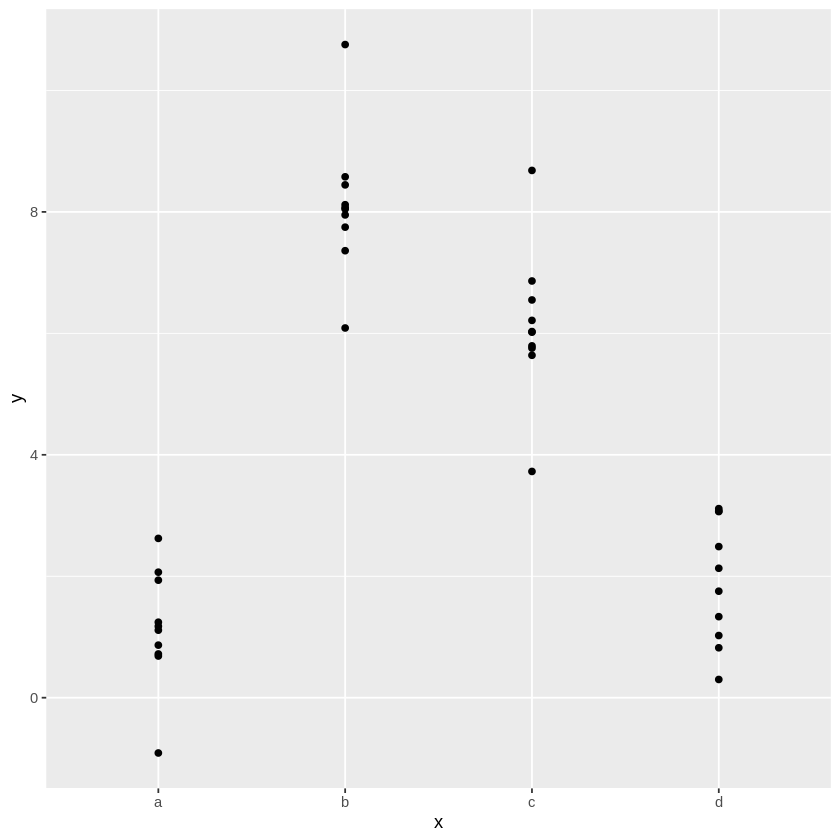

In [24]:
ggplot(sim2) + 
  geom_point(aes(x, y))


We can fit a model to it, and generate predictions:


In [25]:
mod2 <- lm(y ~ x, data = sim2)

grid <- sim2 %>% 
  data_grid(x) %>% 
  add_predictions(mod2)
grid

x,pred
<chr>,<dbl>
a,1.152166
b,8.116039
c,6.127191
d,1.910981



Effectively, a model with a categorical `x` will predict the mean value for each category. (Why? Because the mean minimises the root-mean-squared distance.) That's easy to see if we overlay the predictions on top of the original data:



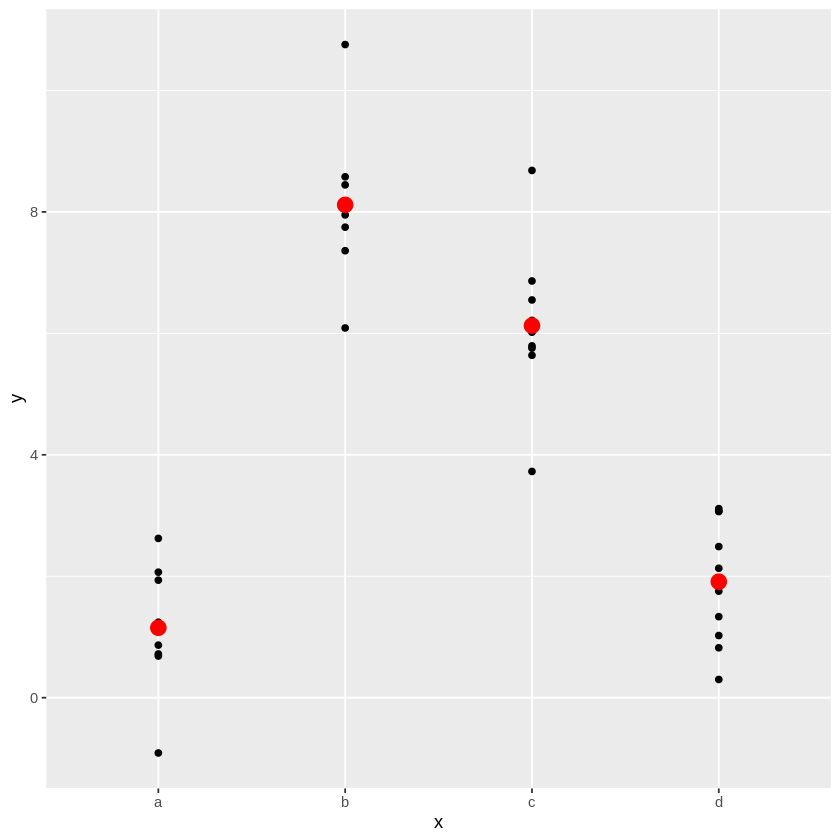

In [26]:
ggplot(sim2, aes(x)) + 
  geom_point(aes(y = y)) +
  geom_point(data = grid, aes(y = pred), colour = "red", size = 4)


You can't make predictions about levels that you didn't observe. Sometimes you'll do this by accident so it's good to recognise this error message:




```r
tibble(x = "e") %>% 
  add_predictions(mod2)
#> Error in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$xlevels): factor x has new level e
```



### Interactions (continuous and categorical)

What happens when you combine a continuous and a categorical variable?  `sim3` contains a categorical predictor and a continuous predictor. We can visualise it with a simple plot:



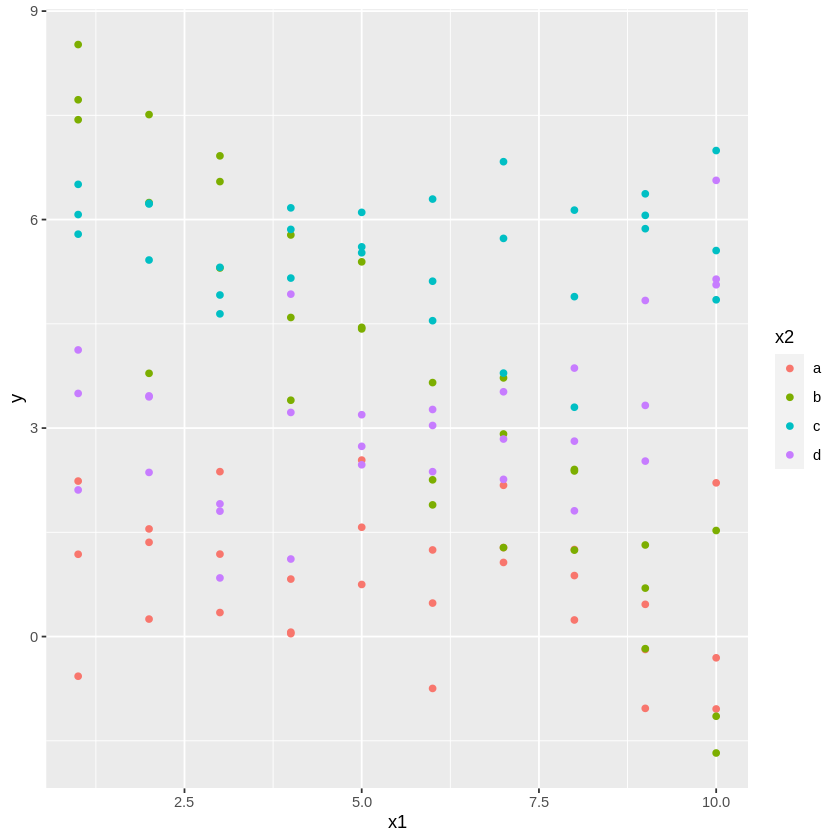

In [28]:
ggplot(sim3, aes(x1, y)) + 
  geom_point(aes(colour = x2))


There are two possible models you could fit to this data:



In [29]:
mod1 <- lm(y ~ x1 + x2, data = sim3)
mod2 <- lm(y ~ x1 * x2, data = sim3)


When you add variables with `+`, the model will estimate each effect independent of all the others. It's possible to fit the so-called interaction by using `*`. For example, `y ~ x1 * x2` is translated to `y = a_0 + a_1 * x1 + a_2 * x2 + a_12 * x1 * x2`. Note that whenever you use `*`, both the interaction and the individual components are included in the model.

To visualise these models we need two new tricks:

1.  We have two predictors, so we need to give `data_grid()` both variables. 
    It finds all the unique values of `x1` and `x2` and then generates all
    combinations. 
   
1.  To generate predictions from both models simultaneously, we can use 
    `gather_predictions()` which adds each prediction as a row. The
    complement of `gather_predictions()` is `spread_predictions()` which adds 
    each prediction to a new column.
    
Together this gives us:



In [30]:
grid <- sim3 %>% 
  data_grid(x1, x2) %>% 
  gather_predictions(mod1, mod2)
grid

model,x1,x2,pred
<chr>,<int>,<fct>,<dbl>
mod1,1,a,1.6749281
mod1,1,b,4.5627390
mod1,1,c,6.4806640
mod1,1,d,4.0345149
mod1,2,a,1.4781904
mod1,2,b,4.3660012
mod1,2,c,6.2839262
mod1,2,d,3.8377771
mod1,3,a,1.2814526



We can visualise the results for both models on one plot using facetting:



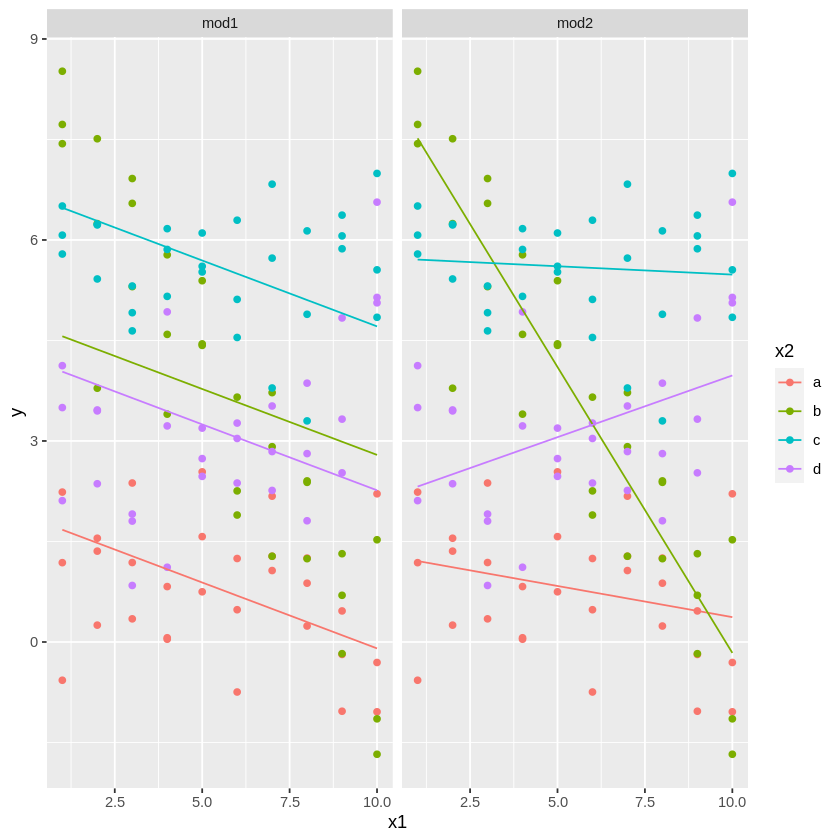

In [31]:
ggplot(sim3, aes(x1, y, colour = x2)) + 
  geom_point() + 
  geom_line(data = grid, aes(y = pred)) + 
  facet_wrap(~ model)


Note that the model that uses `+` has the same slope for each line, but different intercepts. The model that uses `*` has a different slope and intercept for each line.

Which model is better for this data? We can take look at the residuals. Here I've facetted by both model and `x2` because it makes it easier to see the pattern within each group.



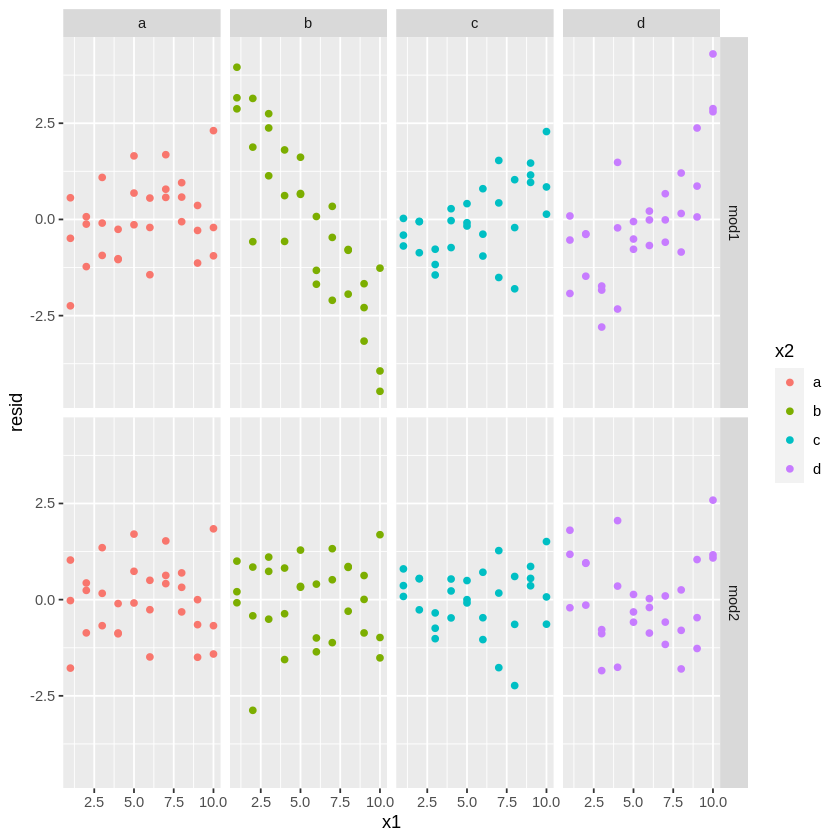

In [32]:
sim3 <- sim3 %>% 
  gather_residuals(mod1, mod2)

ggplot(sim3, aes(x1, resid, colour = x2)) + 
  geom_point() + 
  facet_grid(model ~ x2)


There is little obvious pattern in the residuals for `mod2`. The residuals for `mod1` show that the model has clearly missed some pattern in `b`, and less so, but still present is pattern in `c`, and `d`. You might wonder if there's a precise way to tell which of `mod1` or `mod2` is better. There is, but it requires a lot of mathematical background, and we don't really care. Here, we're interested in a qualitative assessment of whether or not the model has captured the pattern that we're interested in. 

### Interactions (two continuous)

Let's take a look at the equivalent model for two continuous variables. Initially things proceed almost identically to the previous example:



In [33]:
mod1 <- lm(y ~ x1 + x2, data = sim4)
mod2 <- lm(y ~ x1 * x2, data = sim4)

grid <- sim4 %>% 
  data_grid(
    x1 = seq_range(x1, 5), 
    x2 = seq_range(x2, 5) 
  ) %>% 
  gather_predictions(mod1, mod2)
grid

model,x1,x2,pred
<chr>,<dbl>,<dbl>,<dbl>
mod1,-1.0,-1.0,0.99630938
mod1,-1.0,-0.5,-0.39494837
mod1,-1.0,0.0,-1.78620613
mod1,-1.0,0.5,-3.17746388
mod1,-1.0,1.0,-4.56872164
mod1,-0.5,-1.0,1.90714243
mod1,-0.5,-0.5,0.51588467
mod1,-0.5,0.0,-0.87537308
mod1,-0.5,0.5,-2.26663084



Note my use of `seq_range()` inside `data_grid()`. Instead of using every unique value of `x`, I'm going to use a regularly spaced grid of five values between the minimum and maximum numbers. It's probably not super important here, but it's a useful technique in general. There are two other useful arguments to `seq_range()`:

*  `pretty = TRUE` will generate a "pretty" sequence, i.e. something that looks
    nice to the human eye. This is useful if you want to produce tables of 
    output:
 

In [34]:
seq_range(c(0.0123, 0.923423), n = 5)
seq_range(c(0.0123, 0.923423), n = 5, pretty = TRUE)

[1] 0.0123000 0.2400808 0.4678615 0.6956423 0.9234230

[1] 0.0 0.2 0.4 0.6 0.8 1.0

   
*   `trim = 0.1` will trim off 10% of the tail values. This is useful if the 
    variables have a long tailed distribution and you want to focus on generating
    values near the center:
    

In [35]:
x1 <- rcauchy(100)
seq_range(x1, n = 5)
seq_range(x1, n = 5, trim = 0.10)
seq_range(x1, n = 5, trim = 0.25)
seq_range(x1, n = 5, trim = 0.50)

[1] -9.516172 -3.001121  3.513931 10.028982 16.544034

[1] -4.6007179 -2.3627236 -0.1247292  2.1132651  4.3512594

[1] -2.2105929 -1.1704519 -0.1303109  0.9098301  1.9499711

[1] -1.0382129 -0.6011695 -0.1641261  0.2729173  0.7099606


*   `expand = 0.1` is in some sense the opposite of `trim()` it expands the 
    range by 10%.
 

In [36]:
x2 <- c(0, 1)
seq_range(x2, n = 5)
seq_range(x2, n = 5, expand = 0.10)
seq_range(x2, n = 5, expand = 0.25)
seq_range(x2, n = 5, expand = 0.50)

[1] 0.00 0.25 0.50 0.75 1.00

[1] -0.050  0.225  0.500  0.775  1.050

[1] -0.1250  0.1875  0.5000  0.8125  1.1250

[1] -0.250  0.125  0.500  0.875  1.250


Next let's try and visualise that model. We have two continuous predictors, so you can imagine the model like a 3d surface. We could display that using `geom_tile()`:



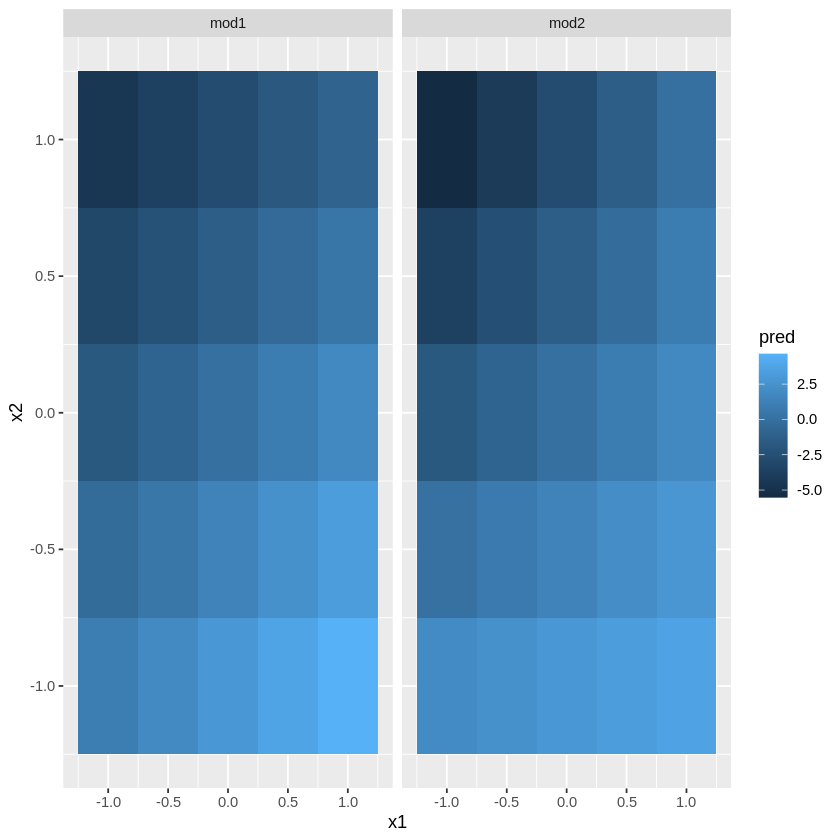

In [37]:
ggplot(grid, aes(x1, x2)) + 
  geom_tile(aes(fill = pred)) + 
  facet_wrap(~ model)


That doesn't suggest that the models are very different! But that's partly an illusion: our eyes and brains are not very good at accurately comparing shades of colour. Instead of looking at the surface from the top, we could look at it from either side, showing multiple slices:



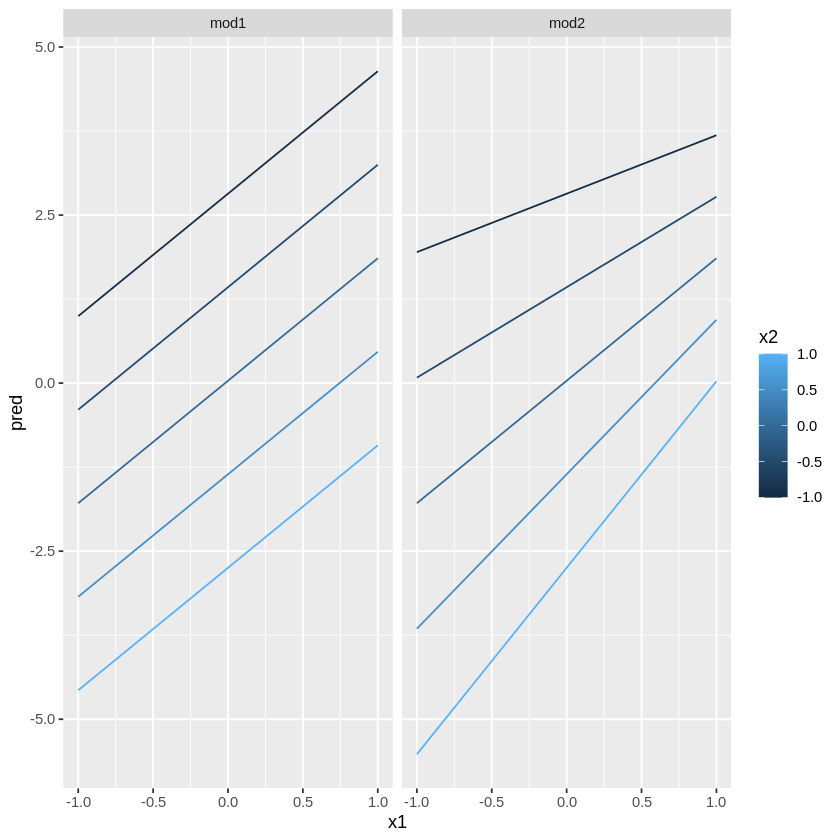

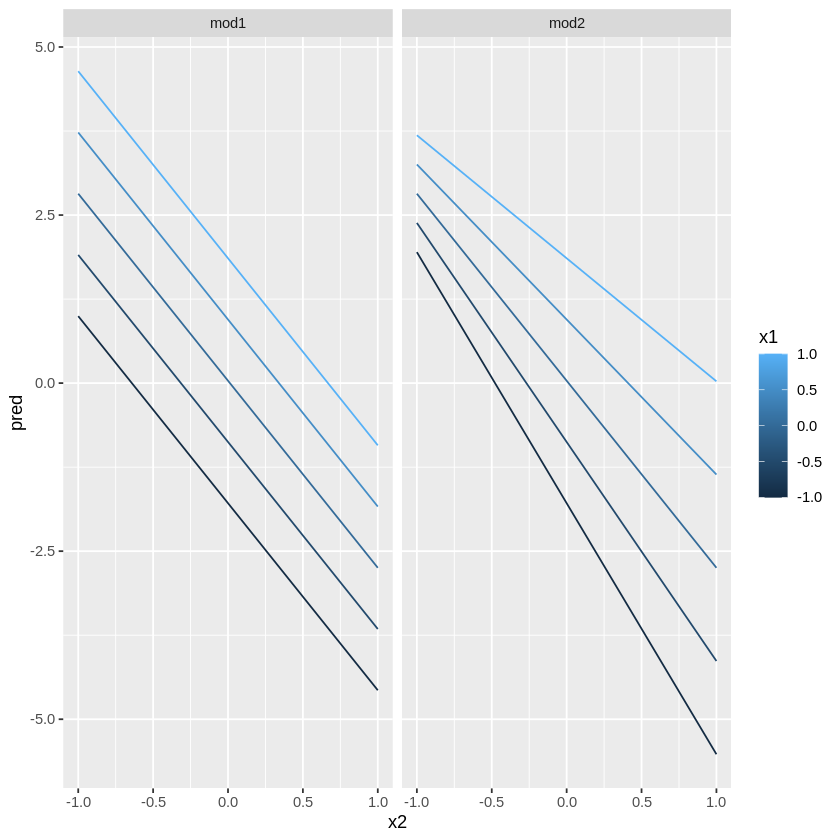

In [38]:
ggplot(grid, aes(x1, pred, colour = x2, group = x2)) + 
  geom_line() +
  facet_wrap(~ model)
ggplot(grid, aes(x2, pred, colour = x1, group = x1)) + 
  geom_line() +
  facet_wrap(~ model)


This shows you that interaction between two continuous variables works basically the same way as for a categorical and continuous variable. An interaction says that there's not a fixed offset: you need to consider both values of `x1` and `x2` simultaneously in order to predict `y`.

You can see that even with just two continuous variables, coming up with good visualisations are hard. But that's reasonable: you shouldn't expect it will be easy to understand how three or more variables simultaneously interact! But again, we're saved a little because we're using models for exploration, and you can gradually build up your model over time. The model doesn't have to be perfect, it just has to help you reveal a little more about your data.

I spent some time looking at the residuals to see if I could figure if `mod2` did better than `mod1`. I think it does, but it's pretty subtle. You'll have a chance to work on it in the exercises.

### Transformations

You can also perform transformations inside the model formula. For example, `log(y) ~ sqrt(x1) + x2` is transformed to `log(y) = a_1 + a_2 * sqrt(x1) + a_3 * x2`. If your transformation involves `+`, `*`, `^`, or `-`, you'll need to wrap it in `I()` so R doesn't treat it like part of the model specification. For example, `y ~ x + I(x ^ 2)` is translated to `y = a_1 + a_2 * x + a_3 * x^2`. If you forget the `I()` and specify `y ~ x ^ 2 + x`, R will compute `y ~ x * x + x`. `x * x` means the interaction of `x` with itself, which is the same as `x`. R automatically drops redundant variables so `x + x` become `x`, meaning that `y ~ x ^ 2 + x` specifies the function `y = a_1 + a_2 * x`. That's probably not what you intended!

Again, if you get confused about what your model is doing, you can always use `model_matrix()` to see exactly what equation `lm()` is fitting:



In [39]:
df <- tribble(
  ~y, ~x,
   1,  1,
   2,  2, 
   3,  3
)
model_matrix(df, y ~ x^2 + x)
model_matrix(df, y ~ I(x^2) + x)

(Intercept),x
<dbl>,<dbl>
1,1
1,2
1,3


(Intercept),I(x^2),x
<dbl>,<dbl>,<dbl>
1,1,1
1,4,2
1,9,3



Transformations are useful because you can use them to approximate non-linear functions. If you've taken a calculus class, you may have heard of Taylor's theorem which says you can approximate any smooth function with an infinite sum of polynomials. That means you can use a polynomial function to get arbitrarily close to a smooth function by fitting an equation like `y = a_1 + a_2 * x + a_3 * x^2 + a_4 * x ^ 3`. Typing that sequence by hand is tedious, so R provides a helper function: `poly()`:



In [40]:
model_matrix(df, y ~ poly(x, 2))

(Intercept),"poly(x, 2)1","poly(x, 2)2"
<dbl>,<dbl>,<dbl>
1,-7.071068e-01,0.4082483
1,-7.850462e-17,-0.8164966
1,7.071068e-01,0.4082483



However there's one major problem with using `poly()`: outside the range of the data, polynomials rapidly shoot off to positive or negative infinity. One safer alternative is to use the natural spline, `splines::ns()`.



In [41]:
library(splines)
model_matrix(df, y ~ ns(x, 2))

(Intercept),"ns(x, 2)1","ns(x, 2)2"
<dbl>,<dbl>,<dbl>
1,0.0000000,0.0000000
1,0.5662628,-0.2108419
1,0.3440969,0.7706021



Let's see what that looks like when we try and approximate a non-linear function:



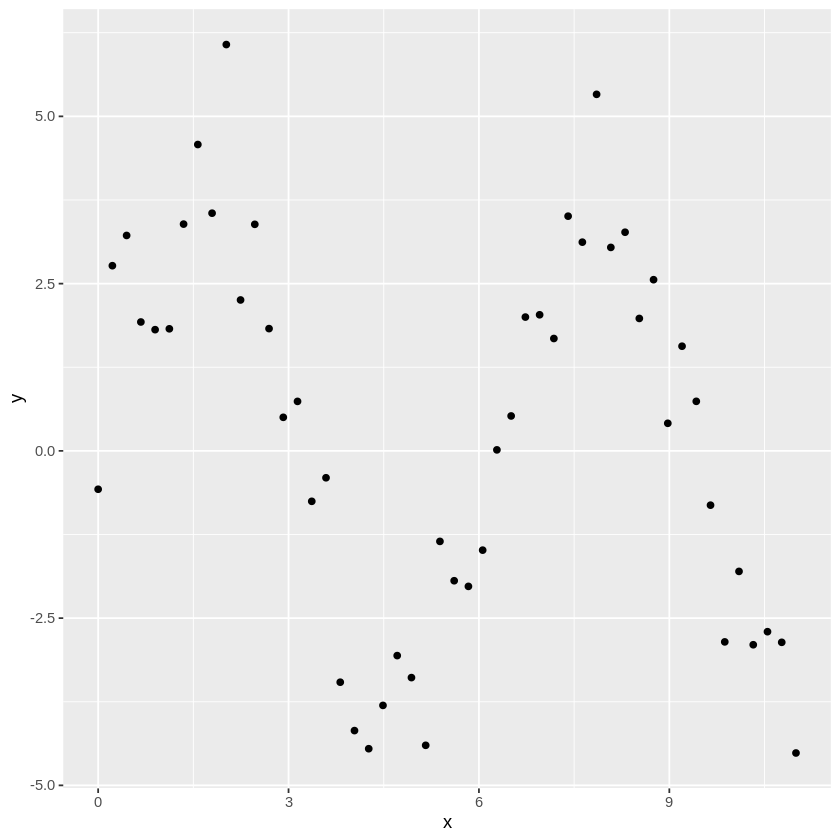

In [42]:
sim5 <- tibble(
  x = seq(0, 3.5 * pi, length = 50),
  y = 4 * sin(x) + rnorm(length(x))
)

ggplot(sim5, aes(x, y)) +
  geom_point()


I'm going to fit five models to this data.



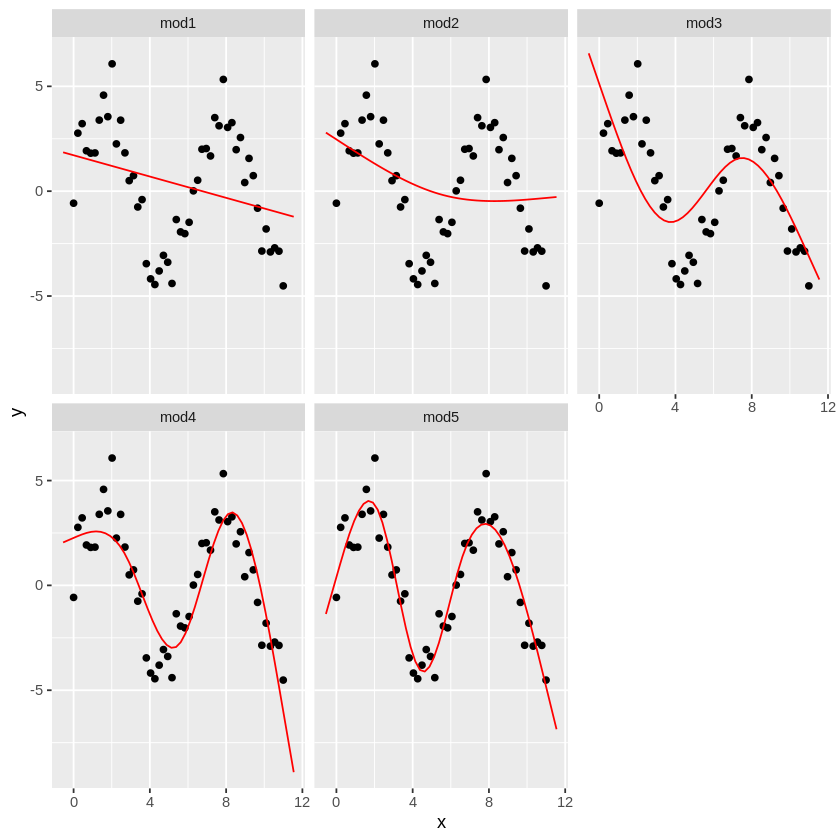

In [43]:
mod1 <- lm(y ~ ns(x, 1), data = sim5)
mod2 <- lm(y ~ ns(x, 2), data = sim5)
mod3 <- lm(y ~ ns(x, 3), data = sim5)
mod4 <- lm(y ~ ns(x, 4), data = sim5)
mod5 <- lm(y ~ ns(x, 5), data = sim5)

grid <- sim5 %>% 
  data_grid(x = seq_range(x, n = 50, expand = 0.1)) %>% 
  gather_predictions(mod1, mod2, mod3, mod4, mod5, .pred = "y")

ggplot(sim5, aes(x, y)) + 
  geom_point() +
  geom_line(data = grid, colour = "red") +
  facet_wrap(~ model)


Notice that the extrapolation outside the range of the data is clearly bad. This is the downside to approximating a function with a polynomial. But this is a very real problem with every model: the model can never tell you if the behaviour is true when you start extrapolating outside the range of the data that you have seen. You must rely on theory and science.

### Exercises

1.  What happens if you repeat the analysis of `sim2` using a model without
    an intercept. What happens to the model equation? What happens to the
    predictions?
    
1.  Use `model_matrix()` to explore the equations generated for the models
    I fit to `sim3` and `sim4`. Why is `*` a good shorthand for interaction?

1.  Using the basic principles, convert the formulas in the following two
    models into functions. (Hint: start by converting the categorical variable
    into 0-1 variables.)

    ```r
    mod1 <- lm(y ~ x1 + x2, data = sim3)
    mod2 <- lm(y ~ x1 * x2, data = sim3)
    ```

1.   For `sim4`,  which of `mod1` and `mod2` is better? I think `mod2` does a 
     slightly better job at removing patterns, but it's pretty subtle. Can you 
     come up with a plot to support my claim? 



## Missing values

Missing values obviously can not convey any information about the relationship between the variables, so modelling functions will drop any rows that contain missing values. R's default behaviour is to silently drop them, but `options(na.action = na.warn)` (run in the prerequisites), makes sure you get a warning.



In [44]:
df <- tribble(
  ~x, ~y,
  1, 2.2,
  2, NA,
  3, 3.5,
  4, 8.3,
  NA, 10
)

mod <- lm(y ~ x, data = df)

Warning message:
“Dropping 2 rows with missing values”



To suppress the warning, set `na.action = na.exclude`:



In [45]:
mod <- lm(y ~ x, data = df, na.action = na.exclude)


You can always see exactly how many observations were used with `nobs()`:



In [46]:
nobs(mod)

[1] 3


## Other model families

This chapter has focussed exclusively on the class of linear models, which assume a relationship of the form `y = a_1 * x1 + a_2 * x2 + ... + a_n * xn`. Linear models additionally assume that the residuals have a normal distribution, which we haven't talked about. There are a large set of model classes that extend the linear model in various interesting ways. Some of them are:

* __Generalised linear models__, e.g. `stats::glm()`. Linear models assume that
  the response is continuous and the error has a normal distribution. 
  Generalised linear models extend linear models to include non-continuous
  responses (e.g. binary data or counts). They work by defining a distance
  metric based on the statistical idea of likelihood.
  
* __Generalised additive models__, e.g. `mgcv::gam()`, extend generalised
  linear models to incorporate arbitrary smooth functions. That means you can
  write a formula like `y ~ s(x)` which becomes an equation like 
  `y = f(x)` and let `gam()` estimate what that function is (subject to some
  smoothness constraints to make the problem tractable).
  
* __Penalised linear models__, e.g. `glmnet::glmnet()`, add a penalty term to
  the distance that penalises complex models (as defined by the distance 
  between the parameter vector and the origin). This tends to make
  models that generalise better to new datasets from the same population.

* __Robust linear models__, e.g. `MASS::rlm()`, tweak the distance to downweight 
  points that are very far away. This makes them less sensitive to the presence
  of outliers, at the cost of being not quite as good when there are no 
  outliers.
  
* __Trees__, e.g. `rpart::rpart()`, attack the problem in a completely different
  way than linear models. They fit a piece-wise constant model, splitting the
  data into progressively smaller and smaller pieces. Trees aren't terribly
  effective by themselves, but they are very powerful when used in aggregate
  by models like __random forests__ (e.g. `randomForest::randomForest()`) or 
  __gradient boosting machines__ (e.g. `xgboost::xgboost`.)

These models all work similarly from a programming perspective. Once you've mastered linear models, you should find it easy to master the mechanics of these other model classes. Being a skilled modeller is a mixture of some good general principles and having a big toolbox of techniques. Now that you've learned some general tools and one useful class of models, you can go on and learn more classes from other sources.
